In [1]:
# import sys
# sys.path.append('../')
# from kaggle_dataset_downloader import download_kaggle_dataset
# download_kaggle_dataset("abrambeyer/openintro-possum", "./")

Can we use total length to predict a possum's head length?<br>
Which possum body dimensions are most correlated with age and sex?<br>
Can we classify a possum's sex by its body dimensions and location? <br>
Can we predict a possum's trapping location from its body dimensions? <br>

### <font color = 'blue'>Features </font><br>
case<br>
site of recording<br>
population area<br>
sex<br>
age<br>
head length<br>
skull width<br>
total length<br>
tail length<br>
foot length<br>
ear conch length<br>
eye size<br>
chest girt<br>
belly girt<br>


- Can we use total length to predict a possum's head length?<br>
- Which possum body dimensions are most correlated with age and sex?<br>
- Can we classify a possum's sex by its body dimensions and location?<br>
- Can we predict a possum's trapping location from its body dimensions?<br>



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, mean_absolute_error

**Importing possum dataset and inspecting the structure, dtypes, missing values and statistical features**

In [3]:
df = pd.read_csv('./data/possum.csv')

In [4]:
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [5]:
df.Pop.value_counts()

Pop
other    58
Vic      46
Name: count, dtype: int64

In [6]:
df.sex.value_counts()

sex
m    61
f    43
Name: count, dtype: int64

**case column is just numbers to cound the enteries and we can drop it**

In [7]:
df.drop('case', axis=1, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   site      104 non-null    int64  
 1   Pop       104 non-null    object 
 2   sex       104 non-null    object 
 3   age       102 non-null    float64
 4   hdlngth   104 non-null    float64
 5   skullw    104 non-null    float64
 6   totlngth  104 non-null    float64
 7   taill     104 non-null    float64
 8   footlgth  103 non-null    float64
 9   earconch  104 non-null    float64
 10  eye       104 non-null    float64
 11  chest     104 non-null    float64
 12  belly     104 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 10.7+ KB


**104 rows and 14 features (104 , 14). datatypes are consisted of object, int and float. we can also see that we have a few missing values**

In [9]:
df.isnull().sum()

site        0
Pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64

In [10]:
df.select_dtypes(include=['float']).describe()

,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
count,102.000000,104.000000,104.000000,104.000000,104.000000,103.000000,104.000000,104.000000,104.000000,104.000000
mean,3.833333,92.602885,56.883654,87.088462,37.009615,68.459223,48.130769,15.046154,27.000000,32.586538
std,1.909244,3.573349,3.113426,4.310549,1.959518,4.395306,4.109380,1.050374,2.045597,2.761949
min,1.000000,82.500000,50.000000,75.000000,32.000000,60.300000,40.300000,12.800000,22.000000,25.000000
25%,2.250000,90.675000,54.975000,84.000000,35.875000,64.600000,44.800000,14.400000,25.500000,31.000000
50%,3.000000,92.800000,56.350000,88.000000,37.000000,68.000000,46.800000,14.900000,27.000000,32.500000
75%,5.000000,94.725000,58.100000,90.000000,38.000000,72.500000,52.000000,15.725000,28.000000,34.125000
max,9.000000,103.100000,68.600000,96.500000,43.000000,77.900000,56.200000,17.800000,32.000000,40.000000


**age and eye have lower range and std compared to other features. for the missing values we can simply fill them with mean values for each feature (age = 3.83 , footlgth = 68.45)**

In [11]:
df.fillna(df['age'].mean(), inplace=True)
df.fillna(df['footlgth'].mean(), inplace=True)

In [12]:
df.columns

Index(['site', 'Pop', 'sex', 'age', 'hdlngth', 'skullw', 'totlngth', 'taill',
       'footlgth', 'earconch', 'eye', 'chest', 'belly'],
      dtype='object')

In [13]:
numerical_features = ['age', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']
def boxplot_per_feature(n, m , dataset):
    fig, axes = plt.subplots(n, m, figsize=(10, 15))
    ax = axes.flatten()
    # Plot each feature against target
    for i, feature in enumerate(dataset[numerical_features]):
        ax[i].boxplot(df[feature])
        ax[i].set_xlabel(feature, color = 'red')
        ax[i].set_ylabel('ranges')
        ax[i].set_title(f'{feature} Boxplot')

    # Hide any empty subplots
    for i in range(len(dataset), len(ax)):
        ax[i].set_visible(False)

    plt.tight_layout()
    plt.show()



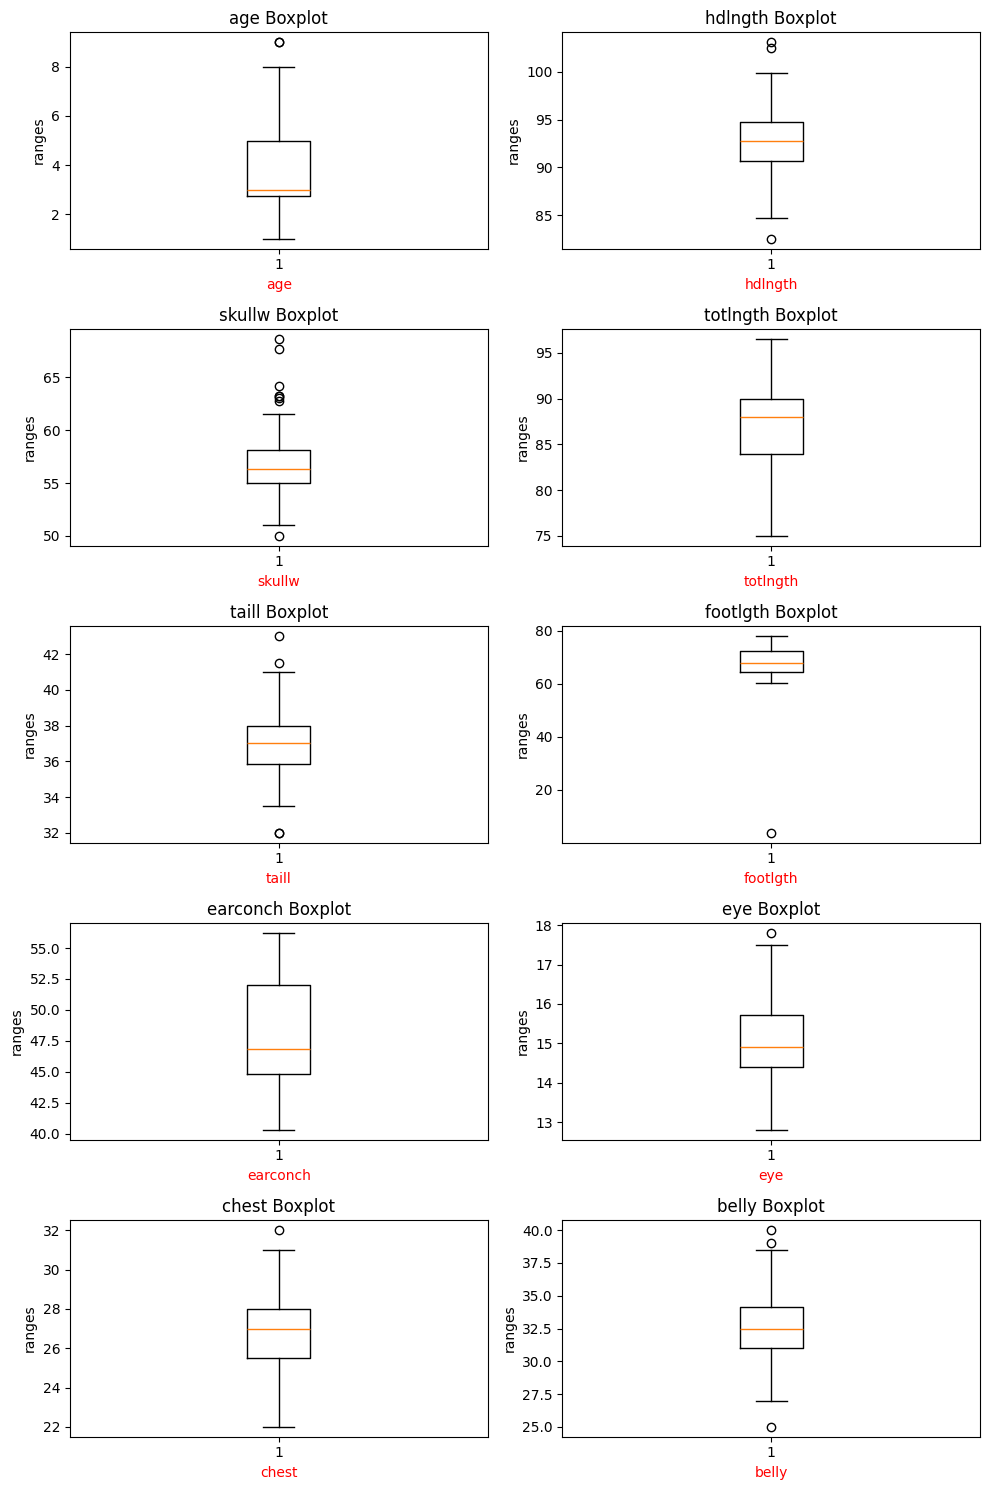

In [14]:
boxplot_per_feature(5, 2 ,df.select_dtypes(include=['float', 'int']))

**for now target value is age**

In [15]:
X = df.drop('age', axis= 1)
y = df.age

In [16]:
X

,site,Pop,sex,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,Vic,m,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,Vic,f,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,Vic,f,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,Vic,f,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,Vic,f,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99,7,other,m,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0
100,7,other,m,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0
101,7,other,f,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0
102,7,other,m,91.5,55.2,82.5,36.5,62.9,45.9,15.4,25.0,29.0


In [17]:
X_labeld = pd.get_dummies(X, columns=['Pop', 'sex'])

In [18]:
X_labeld

,site,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,Pop_Vic,Pop_other,sex_f,sex_m
0,1,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0,True,False,False,True
1,1,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0,True,False,True,False
2,1,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0,True,False,True,False
3,1,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0,True,False,True,False
4,1,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,7,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0,False,True,False,True
100,7,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0,False,True,False,True
101,7,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0,False,True,True,False
102,7,91.5,55.2,82.5,36.5,62.9,45.9,15.4,25.0,29.0,False,True,False,True


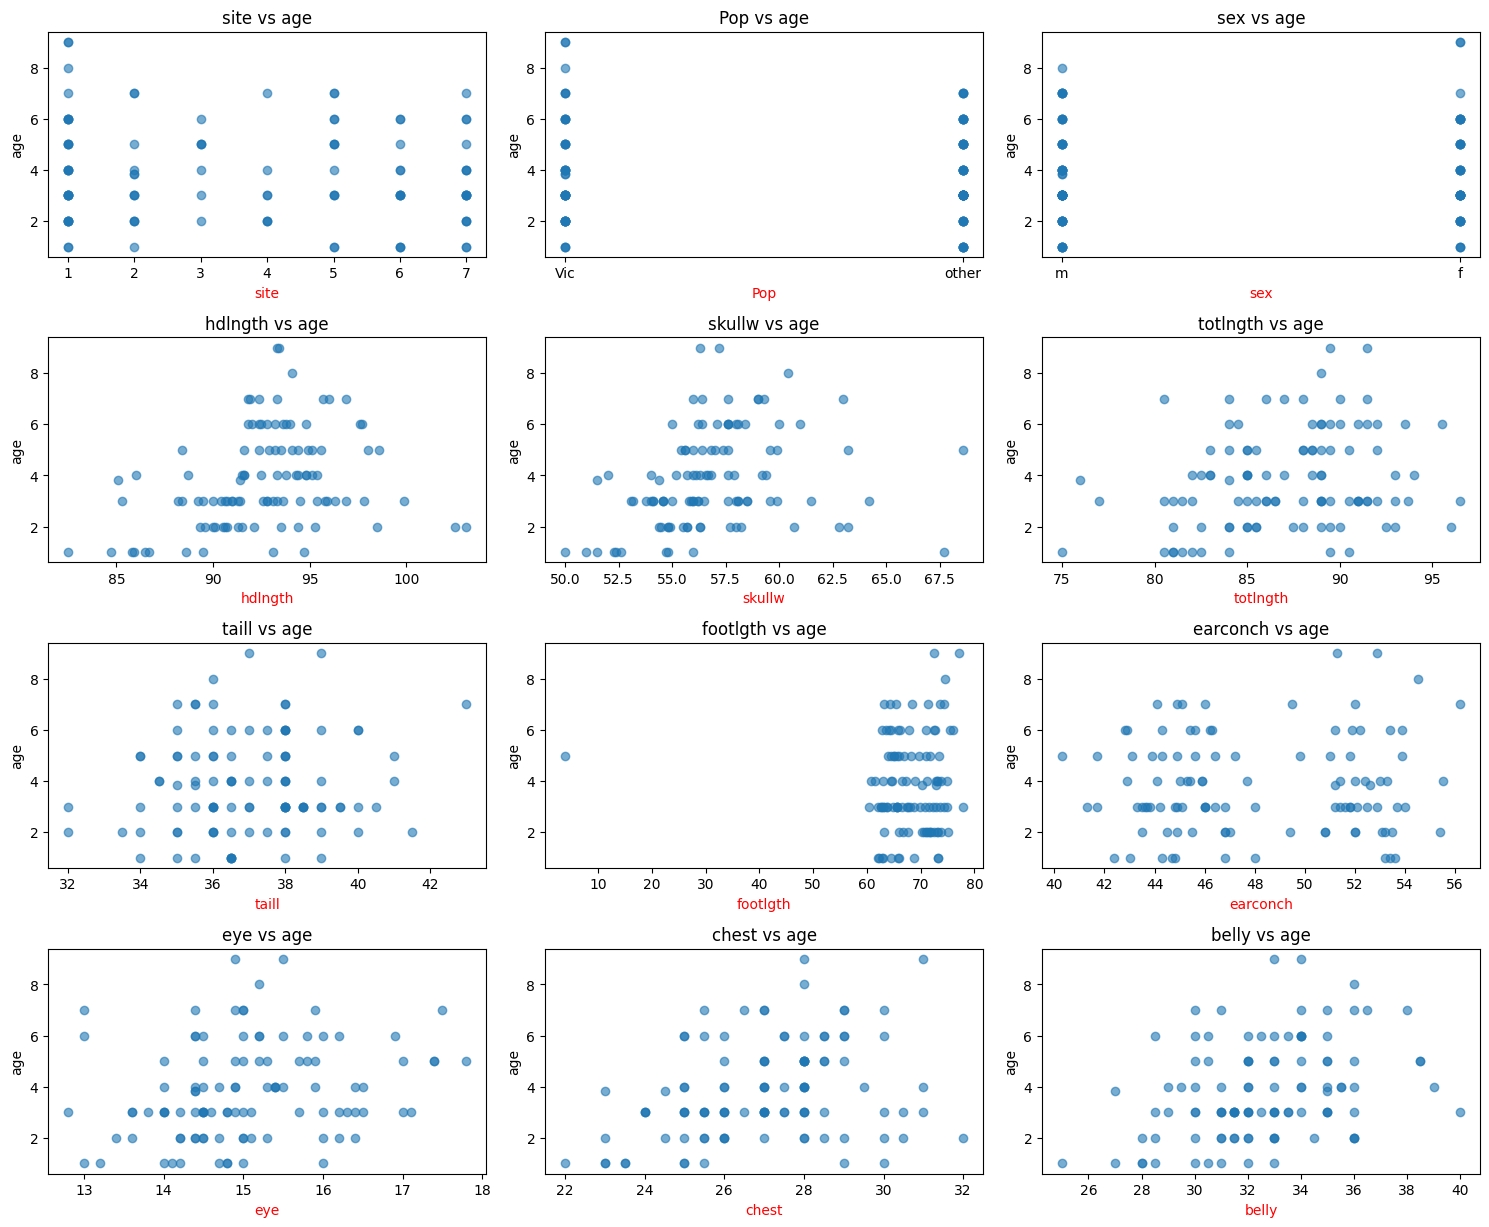

In [19]:
fig, axes = plt.subplots(5, 3, figsize=(15, 15))
ax = axes.flatten()
feature_cols = [col for col in df.columns if col != 'age']

for i, feature in enumerate(feature_cols):
    ax[i].scatter(df[feature], df['age'], alpha=0.6)
    ax[i].set_xlabel(feature, color = 'red')
    ax[i].set_ylabel('age')
    ax[i].set_title(f'{feature} vs age')
for i in range(len(feature_cols), len(ax)):
    ax[i].set_visible(False)

plt.tight_layout()
plt.show()

In [20]:
pearson_analysis = X_labeld.copy()

In [21]:
pearson_analysis['age'] = y

In [22]:
corr_matrix = pearson_analysis.corr()

In [23]:
print(corr_matrix['age'].sort_values(ascending=False))

age          1.000000
belly        0.345825
chest        0.325303
hdlngth      0.311848
skullw       0.279955
totlngth     0.250970
eye          0.234669
taill        0.117274
Pop_Vic      0.085747
sex_f        0.063995
earconch     0.052943
footlgth     0.020900
sex_m       -0.063995
Pop_other   -0.085747
site        -0.130799
Name: age, dtype: float64


In [24]:
mutual_info = mutual_info_regression(X_labeld, y)

In [25]:
mutual_info

array([0.        , 0.24628531, 0.12458958, 0.0860403 , 0.01474911,
       0.        , 0.        , 0.02799119, 0.06000303, 0.        ,
       0.00145104, 0.        , 0.        , 0.        ])

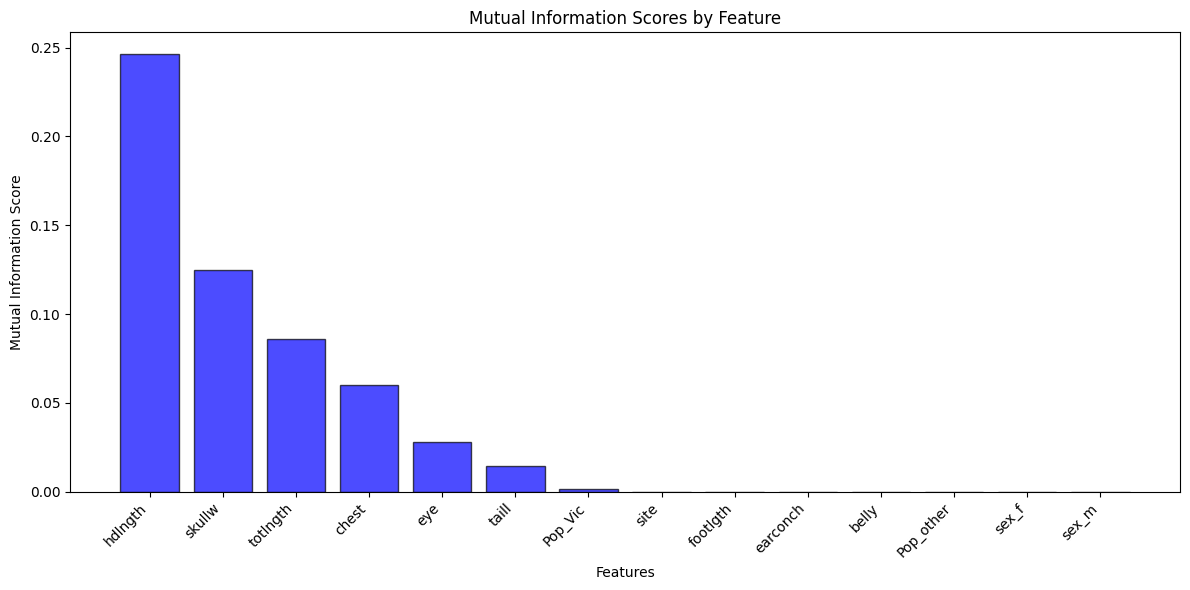

In [26]:
mutual_info_series = pd.Series(mutual_info, index=X_labeld.columns, name='Mutual_Info')
mutual_info_sorted = mutual_info_series.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(mutual_info_sorted.index, mutual_info_sorted.values, 
        color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores by Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Simple modelling and analysis**

In [27]:
lr = LinearRegression()

In [28]:
scores = cross_val_score(
    lr, X_labeld, y, scoring='neg_mean_absolute_error', cv=5)

In [29]:
scores = np.array([-2.12849853, -2.26501191, -1.69445374, -1.28598937, -1.54699262])

# Convert to actual MAE (positive values)
mae_scores = -scores
print(f"MAE scores: {mae_scores}")
# Output: [2.12849853, 2.26501191, 1.69445374, 1.28598937, 1.54699262]

# Get the average performance
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()

print(f"Mean MAE: {mean_mae:.4f}")
print(f"Std MAE: {std_mae:.4f}")

MAE scores: [2.12849853 2.26501191 1.69445374 1.28598937 1.54699262]
Mean MAE: 1.7842
Std MAE: 0.3639


In [30]:
from scipy.stats import normaltest, boxcox

In [31]:
normal_test_features = ['hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth','earconch', 'eye', 'chest', 'belly']
for i , val in enumerate(normal_test_features):
    print(f'{val} normal test is equale to {normaltest(X_labeld[val]).pvalue}')

hdlngth normal test is equale to 0.24117848327111197
skullw normal test is equale to 6.278116082550539e-06
totlngth normal test is equale to 0.47190438854803596
taill normal test is equale to 0.48683326496779167
footlgth normal test is equale to 4.929784531561764e-35
earconch normal test is equale to 4.2763585788463286e-18
eye normal test is equale to 0.23941740953313514
chest normal test is equale to 0.8442483380509291
belly normal test is equale to 0.8176326363384648


In [32]:
X_labeld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   site       104 non-null    int64  
 1   hdlngth    104 non-null    float64
 2   skullw     104 non-null    float64
 3   totlngth   104 non-null    float64
 4   taill      104 non-null    float64
 5   footlgth   104 non-null    float64
 6   earconch   104 non-null    float64
 7   eye        104 non-null    float64
 8   chest      104 non-null    float64
 9   belly      104 non-null    float64
 10  Pop_Vic    104 non-null    bool   
 11  Pop_other  104 non-null    bool   
 12  sex_f      104 non-null    bool   
 13  sex_m      104 non-null    bool   
dtypes: bool(4), float64(9), int64(1)
memory usage: 8.7 KB


In [33]:
# Convert booleans to integers
X_labeld['Pop_Vic'] = X_labeld['Pop_Vic'].astype(int)
X_labeld['Pop_other'] = X_labeld['Pop_other'].astype(int)
X_labeld['sex_f'] = X_labeld['sex_f'].astype(int)
X_labeld['sex_m'] = X_labeld['sex_m'].astype(int)

In [34]:
dest_features = ['hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth','earconch', 'eye', 'chest', 'belly']
def dest_plot(n, m , dataset):
    fig, axes = plt.subplots(n, m, figsize=(10, 15))
    ax = axes.flatten()
    # Plot each feature against target
    for i, feature in enumerate(dataset[dest_features]):
        ax[i].hist(df[feature], edgecolor='black', bins = 20)
        ax[i].set_xlabel(feature, color = 'red')
        ax[i].set_ylabel('ranges')
        ax[i].set_title(f'{feature} Boxplot')

    # Hide any empty subplots
    for i in range(len(dataset[dest_features]), len(ax)):
        ax[i].set_visible(False)

    plt.tight_layout()
    plt.show()


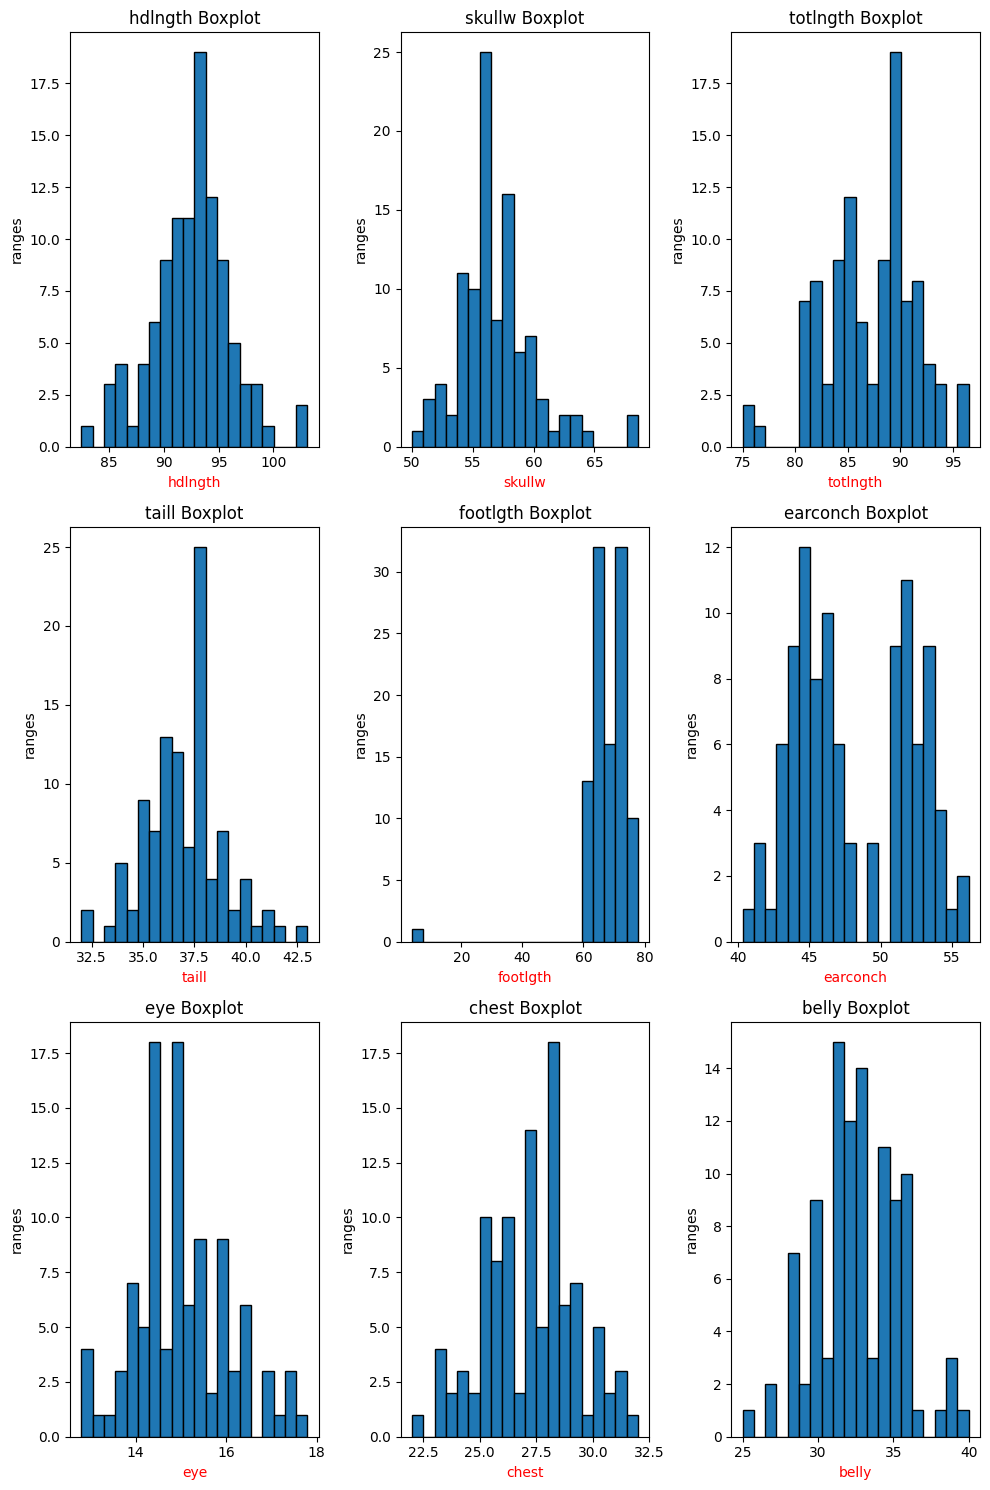

In [35]:
dest_plot(3, 3, X_labeld)

In [36]:
X_labeld.skullw = boxcox(X_labeld.skullw)[0]

In [37]:
scores_2 = cross_val_score(
    lr, X_labeld, y, scoring='neg_mean_absolute_error', cv=5)

In [38]:
scores = np.array([-2.12849853, -2.26501191, -1.69445374, -1.28598937, -1.54699262])
mae_scores = -scores
print(f"MAE scores: {mae_scores}")
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()
print(f"Mean MAE: {mean_mae:.4f}")
print(f"Std MAE: {std_mae:.4f}")

MAE scores: [2.12849853 2.26501191 1.69445374 1.28598937 1.54699262]
Mean MAE: 1.7842
Std MAE: 0.3639


In [39]:
scores_2 = np.array([-2.12557357, -2.26337081, -1.69472629, -1.29262749, -1.54345071])
mae_scores = -scores
print(f"MAE scores: {mae_scores}")
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()
print(f"Mean MAE: {mean_mae:.4f}")
print(f"Std MAE: {std_mae:.4f}")

MAE scores: [2.12849853 2.26501191 1.69445374 1.28598937 1.54699262]
Mean MAE: 1.7842
Std MAE: 0.3639


In [40]:
X_labeld

,site,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,Pop_Vic,Pop_other,sex_f,sex_m
0,1,94.1,0.302251,89.0,36.0,74.5,54.5,15.2,28.0,36.0,1,0,0,1
1,1,92.5,0.302251,91.5,36.5,72.5,51.2,16.0,28.5,33.0,1,0,1,0
2,1,94.0,0.302251,95.5,39.0,75.4,51.9,15.5,30.0,34.0,1,0,1,0
3,1,93.2,0.302251,92.0,38.0,76.1,52.2,15.2,28.0,34.0,1,0,1,0
4,1,91.5,0.302251,85.5,36.0,71.0,53.2,15.1,28.5,33.0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,7,89.5,0.302251,81.5,36.5,66.0,46.8,14.8,23.0,27.0,0,1,0,1
100,7,88.6,0.302251,82.5,39.0,64.4,48.0,14.0,25.0,33.0,0,1,0,1
101,7,92.4,0.302251,89.0,38.0,63.5,45.4,13.0,25.0,30.0,0,1,1,0
102,7,91.5,0.302251,82.5,36.5,62.9,45.9,15.4,25.0,29.0,0,1,0,1


In [41]:
lr.fit(X_labeld, y)
perm_importance = permutation_importance(lr, X_labeld, y, n_repeats=10, random_state=42, n_jobs=-1)

In [42]:
perm_importance.importances_mean

array([0.09040856, 0.01932389, 0.03397714, 0.01675092, 0.0130473 ,
       0.0079177 , 0.01433116, 0.04455999, 0.00665748, 0.0786501 ,
       0.08298169, 0.08278232, 0.00273246, 0.00256365])

In [43]:
feature_names = [i for i in ['site','Pop_Vic','Pop_other','sex_f','sex_m','hdlngth', 'skullw', 'totlngth', 'taill',
       'footlgth', 'earconch', 'eye', 'chest', 'belly']]

In [44]:
linear_reg_importances = pd.Series(perm_importance.importances_mean, index=feature_names, name='Mutual_Info')

In [45]:
linear_reg_importances

site         0.090409
Pop_Vic      0.019324
Pop_other    0.033977
sex_f        0.016751
sex_m        0.013047
hdlngth      0.007918
skullw       0.014331
totlngth     0.044560
taill        0.006657
footlgth     0.078650
earconch     0.082982
eye          0.082782
chest        0.002732
belly        0.002564
Name: Mutual_Info, dtype: float64

In [46]:
dtr_importances = linear_reg_importances.sort_values(ascending=False)
dtr_importances.index

Index(['site', 'earconch', 'eye', 'footlgth', 'totlngth', 'Pop_other',
       'Pop_Vic', 'sex_f', 'skullw', 'sex_m', 'hdlngth', 'taill', 'chest',
       'belly'],
      dtype='object')

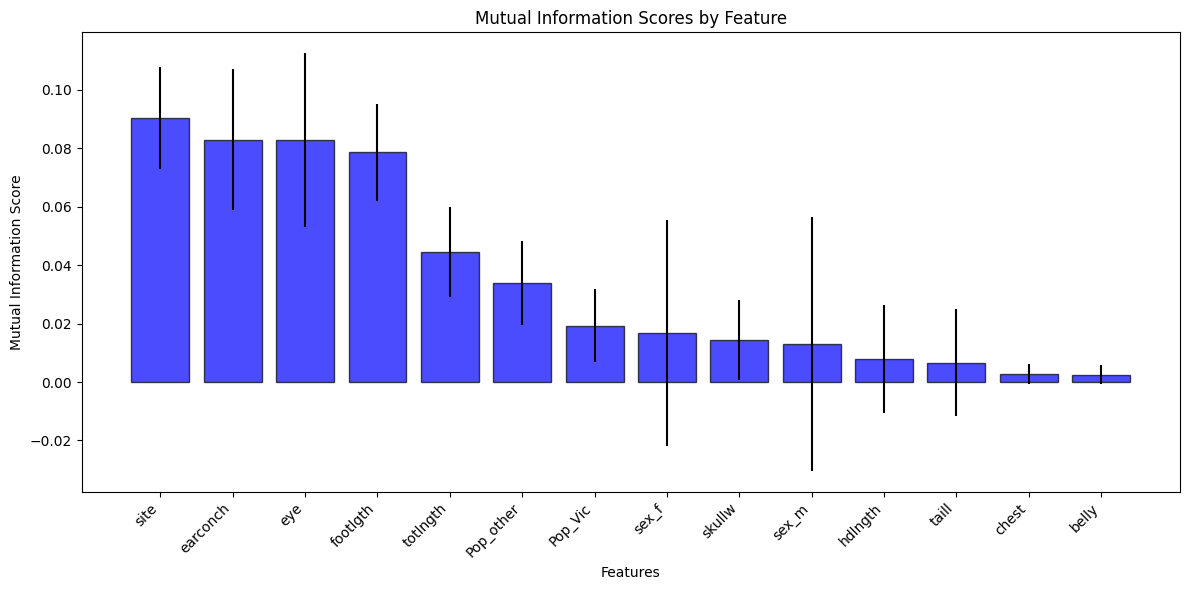

In [47]:
# Sort for better visualization
dtr_importances = linear_reg_importances.sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(dtr_importances.index, dtr_importances.values, 
        color='blue', edgecolor='black', alpha=0.7, yerr=perm_importance.importances_std)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores by Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

In [49]:
gbt = GradientBoostingRegressor()

In [51]:
scores = cross_val_score(gbt, X_labeld, y, cv=5, scoring='neg_mean_absolute_error')

In [54]:
scores

array([-2.26738895, -1.4922026 , -1.30991233, -1.4543261 , -1.56943651])

In [55]:
scores = np.array([-2.26738895, -1.4922026 , -1.30991233, -1.4543261 , -1.56943651])

# Convert to actual MAE (positive values)
mae_scores = -scores
print(f"MAE scores: {mae_scores}")
# Output: [2.12849853, 2.26501191, 1.69445374, 1.28598937, 1.54699262]

# Get the average performance
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()

print(f"Mean MAE: {mean_mae:.4f}")
print(f"Std MAE: {std_mae:.4f}")

MAE scores: [2.26738895 1.4922026  1.30991233 1.4543261  1.56943651]
Mean MAE: 1.6187
Std MAE: 0.3351
